In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [59]:
df = pd.read_csv('cleaned_dataset_with_financialratios.csv')

In [60]:
df

,Unnamed: 0,Date,Open,High,Low,Close,Volume,Year,Sentiment,SPY,Debt_to_Equity_Ratio,Revenue_Growth,operatingCashflow,Free_Cash_Flow,ROE,reportedEPS,PE_Ratio
0,0,2010-01-04,55.52,55.73,52.9600,53.48,2462800.0,2010,NaN,53.48,2.413296,5.062866,105817000,83384000,0.155230,0.08,668.500000
1,1,2010-01-05,53.57,53.60,50.8100,51.51,3393300.0,2010,NaN,51.51,2.413296,5.062866,105817000,83384000,0.155230,0.08,643.875000
2,2,2010-01-06,51.53,53.71,50.3800,53.32,3327200.0,2010,NaN,53.32,2.413296,5.062866,105817000,83384000,0.155230,0.08,666.500000
3,3,2010-01-07,54.12,54.30,52.2406,52.40,1422200.0,2010,1.0,52.40,2.413296,5.062866,105817000,83384000,0.155230,0.08,655.000000
4,4,2010-01-08,52.49,54.20,52.2600,53.30,1168700.0,2010,NaN,53.30,2.413296,5.062866,105817000,83384000,0.155230,0.08,666.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3532,3532,2024-01-17,484.50,486.21,475.2642,480.33,4894593.0,2024,NaN,480.33,1.366974,3.408667,1663014000,1581382000,0.045552,2.11,227.644550
3533,3533,2024-01-18,480.03,485.77,478.0200,485.31,4054399.0,2024,NaN,485.31,1.366974,3.408667,1663014000,1581382000,0.045552,2.11,230.004739
3534,3534,2024-01-19,484.98,485.67,476.0600,482.95,5672351.0,2024,NaN,482.95,1.366974,3.408667,1663014000,1581382000,0.045552,2.11,228.886256
3535,3535,2024-01-22,487.55,489.80,479.9000,485.71,5212309.0,2024,NaN,485.71,1.366974,3.408667,1663014000,1581382000,0.045552,2.11,230.194313


In [61]:
df.pop("Unnamed: 0")

0          0
1          1
2          2
3          3
4          4
        ... 
3532    3532
3533    3533
3534    3534
3535    3535
3536    3536
Name: Unnamed: 0, Length: 3537, dtype: int64

In [62]:
# Spliting Data as Train and Validation
length_data = len(df)     # rows that data has
split_ratio = 0.7           # %70 train + %30 validation
length_train = round(length_data * split_ratio)  
length_test = length_data - length_train
print("Data length :", length_data)
print("Train data length :", length_train)
print("Test data length :", length_test)

Data length : 3537
Train data length : 2476
Test data length : 1061


In [63]:
train_data = df[:length_train]
train_data['Date'] = pd.to_datetime(train_data['Date'])  # converting to date time object
train_data

C:\Users\Samantha\AppData\Local\Temp\ipykernel_960\2531073395.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Date'] = pd.to_datetime(train_data['Date'])  # converting to date time object


,Date,Open,High,Low,Close,Volume,Year,Sentiment,SPY,Debt_to_Equity_Ratio,Revenue_Growth,operatingCashflow,Free_Cash_Flow,ROE,reportedEPS,PE_Ratio
0,2010-01-04,55.52,55.73,52.9600,53.48,2462800.0,2010,NaN,53.48,2.413296,5.062866,105817000,83384000,0.155230,0.08,668.500000
1,2010-01-05,53.57,53.60,50.8100,51.51,3393300.0,2010,NaN,51.51,2.413296,5.062866,105817000,83384000,0.155230,0.08,643.875000
2,2010-01-06,51.53,53.71,50.3800,53.32,3327200.0,2010,NaN,53.32,2.413296,5.062866,105817000,83384000,0.155230,0.08,666.500000
3,2010-01-07,54.12,54.30,52.2406,52.40,1422200.0,2010,1.0,52.40,2.413296,5.062866,105817000,83384000,0.155230,0.08,655.000000
4,2010-01-08,52.49,54.20,52.2600,53.30,1168700.0,2010,NaN,53.30,2.413296,5.062866,105817000,83384000,0.155230,0.08,666.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2471,2019-10-28,278.05,285.75,277.3500,281.86,6172256.0,2019,NaN,281.86,3.509464,6.536287,-501794000,-547127000,0.096953,1.47,191.741497
2472,2019-10-29,281.87,284.41,277.5450,281.21,4356181.0,2019,NaN,281.21,3.509464,6.536287,-501794000,-547127000,0.096953,1.47,191.299320
2473,2019-10-30,284.34,293.49,283.0000,291.45,9345562.0,2019,NaN,291.45,3.509464,6.536287,-501794000,-547127000,0.096953,1.47,198.265306
2474,2019-10-31,291.00,291.45,284.7800,287.41,5090021.0,2019,NaN,287.41,3.509464,6.536287,-501794000,-547127000,0.096953,1.47,195.517007


In [64]:
validation_data = df[length_train:]
validation_data['Date'] = pd.to_datetime(validation_data['Date'])  # converting to date time object
validation_data

C:\Users\Samantha\AppData\Local\Temp\ipykernel_960\264510040.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data['Date'] = pd.to_datetime(validation_data['Date'])  # converting to date time object


,Date,Open,High,Low,Close,Volume,Year,Sentiment,SPY,Debt_to_Equity_Ratio,Revenue_Growth,operatingCashflow,Free_Cash_Flow,ROE,reportedEPS,PE_Ratio
2476,2019-11-04,288.00,295.39,287.1600,292.86,5566213.0,2019,NaN,292.86,3.509464,6.536287,-501794000,-547127000,0.096953,1.47,199.224490
2477,2019-11-05,289.99,291.19,286.3100,288.03,4062370.0,2019,NaN,288.03,3.509464,6.536287,-501794000,-547127000,0.096953,1.47,195.938776
2478,2019-11-06,288.19,290.56,285.8400,288.59,3438257.0,2019,NaN,288.59,3.509464,6.536287,-501794000,-547127000,0.096953,1.47,196.319728
2479,2019-11-07,290.70,298.19,288.2679,289.57,5928471.0,2019,NaN,289.57,3.509464,6.536287,-501794000,-547127000,0.096953,1.47,196.986395
2480,2019-11-08,288.73,293.99,287.5050,291.57,4509588.0,2019,NaN,291.57,3.509464,6.536287,-501794000,-547127000,0.096953,1.47,198.346939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3532,2024-01-17,484.50,486.21,475.2642,480.33,4894593.0,2024,NaN,480.33,1.366974,3.408667,1663014000,1581382000,0.045552,2.11,227.644550
3533,2024-01-18,480.03,485.77,478.0200,485.31,4054399.0,2024,NaN,485.31,1.366974,3.408667,1663014000,1581382000,0.045552,2.11,230.004739
3534,2024-01-19,484.98,485.67,476.0600,482.95,5672351.0,2024,NaN,482.95,1.366974,3.408667,1663014000,1581382000,0.045552,2.11,228.886256
3535,2024-01-22,487.55,489.80,479.9000,485.71,5212309.0,2024,NaN,485.71,1.366974,3.408667,1663014000,1581382000,0.045552,2.11,230.194313


In [65]:
dataset_train = train_data.Close.values
dataset_train.shape

(2476,)

In [66]:
# Change 1d array to 2d array
# Changing shape from (1692,) to (1692,1)
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(2476, 1)

In [67]:
# Nomralise / feature scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))


# scaling dataset
dataset_train_scaled = scaler.fit_transform(dataset_train)

dataset_train_scaled.shape

(2476, 1)

Create X_train and y_train from Train data
- We have train data composed of stock close prices over days
- So, it has 2476 prices corresponding 1184 days
- My aim is to predict the close price of the next day.
- I can use a time step of 50 days.
- I will pick first 50 close prices (0 to 50), 1st 50 price will be in X_train data
- Then predict the price of 51th day; and 51th price will be in y_train data
- Again, i will pick prices from 1 to 51, those will be in X_train data
- Then predict the next days price, 52nd price will be in y_train data

In [68]:
X_train = []
y_train = []

time_step = 50

for i in range(time_step, length_train):
    X_train.append(dataset_train_scaled[i-time_step:i,0])
    y_train.append(dataset_train_scaled[i,0])
    
# convert list to array
X_train, y_train = np.array(X_train), np.array(y_train)

In [69]:
print("Shape of X_train before reshape :",X_train.shape)
print("Shape of y_train before reshape :",y_train.shape)

Shape of X_train before reshape : (2426, 50)
Shape of y_train before reshape : (2426,)


In [70]:
# Reshape
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

print("Shape of X_train after reshape :",X_train.shape)
print("Shape of y_train after reshape :",y_train.shape)

Shape of X_train after reshape : (2426, 50, 1)
Shape of y_train after reshape : (2426, 1)


## Model 1

In [135]:
#build LSTM + GRU model

from keras.models import Sequential
from keras.layers import LSTM, GRU, Dropout, Dense

regressor = Sequential()

# 1st LSTM layer with Dropout regularisation
regressor.add(LSTM(units=512, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.3))

# 1st GRU layer
regressor.add(GRU(units=256, return_sequences=True))
regressor.add(Dropout(0.2))

# 2nd LSTM layer with Dropout regularisation
regressor.add(LSTM(units=128, return_sequences=True))
regressor.add(Dropout(0.2))

# 2nd GRU layer
regressor.add(GRU(units=64, activation='tanh'))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

regressor.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 50, 512)           1052672   
                                                                 
 dropout_33 (Dropout)        (None, 50, 512)           0         
                                                                 
 gru_20 (GRU)                (None, 50, 256)           591360    
                                                                 
 dropout_34 (Dropout)        (None, 50, 256)           0         
                                                                 
 lstm_21 (LSTM)              (None, 50, 128)           197120    
                                                                 
 dropout_35 (Dropout)        (None, 50, 128)           0         
                                                                 
 gru_21 (GRU)                (None, 64)              

In [136]:
# Train the model
regressor.compile(optimizer='adam',loss='mean_squared_error')
history = regressor.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
76/76 [==============================] - 19s 159ms/step - loss: 44146900138869104050176.0000
Epoch 2/30
76/76 [==============================] - 12s 161ms/step - loss: 44146900138869104050176.0000
Epoch 3/30
76/76 [==============================] - 12s 162ms/step - loss: 44146904642468731420672.0000
Epoch 4/30
76/76 [==============================] - 12s 164ms/step - loss: 44146900138869104050176.0000
Epoch 5/30
76/76 [==============================] - 12s 161ms/step - loss: 44146900138869104050176.0000
Epoch 6/30
76/76 [==============================] - 12s 161ms/step - loss: 44146913649667986161664.0000
Epoch 7/30
76/76 [==============================] - 11s 150ms/step - loss: 44146900138869104050176.0000
Epoch 8/30
76/76 [==============================] - 11s 150ms/step - loss: 44146904642468731420672.0000
Epoch 9/30
76/76 [==============================] - 11s 149ms/step - loss: 44146900138869104050176.0000
Epoch 10/30
76/76 [==============================] - 12s 153ms/s

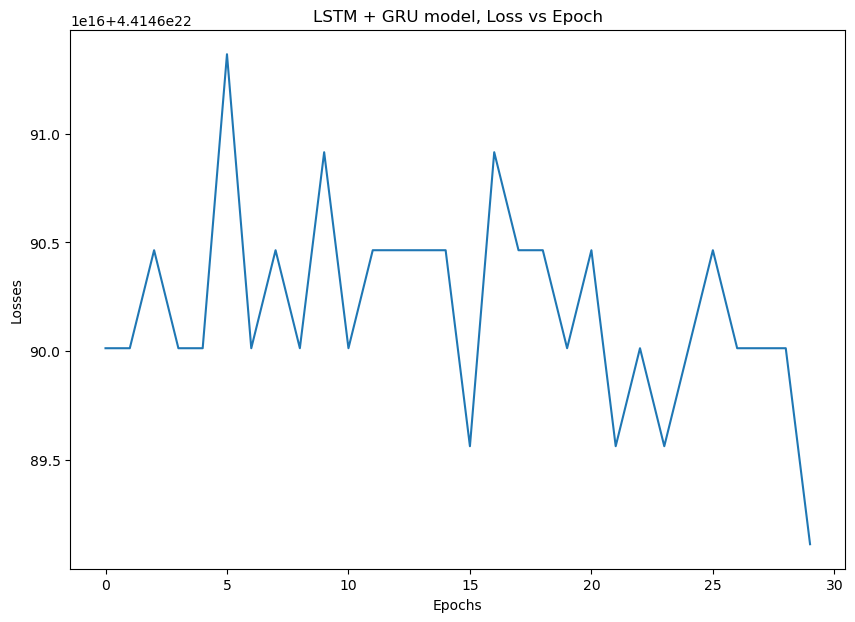

In [137]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM + GRU model, Loss vs Epoch")
plt.show()

Evaluate Test Data

In [138]:
X_test = []
y_test = []

time_step = 50

for i in range(time_step, length_train):
    X_test.append(dataset_train_scaled[i-time_step:i,0])
    y_test.append(dataset_train_scaled[i,0])
    
# convert list to array
X_test, y_test = np.array(X_test), np.array(y_test)

In [139]:
test_loss = regressor.evaluate(X_test, y_test)
print(f"Test loss: {test_loss:.4f}")

76/76 [==============================] - 6s 56ms/step - loss: 24491.7832
Test loss: 24491.7832


Model Predictions

In [140]:
y_pred = regressor.predict(X_train)  # predictions
y_pred = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_pred.shape

76/76 [==============================] - 6s 57ms/step


(2426, 1)

In [141]:
y_train = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train.shape

(2426, 1)

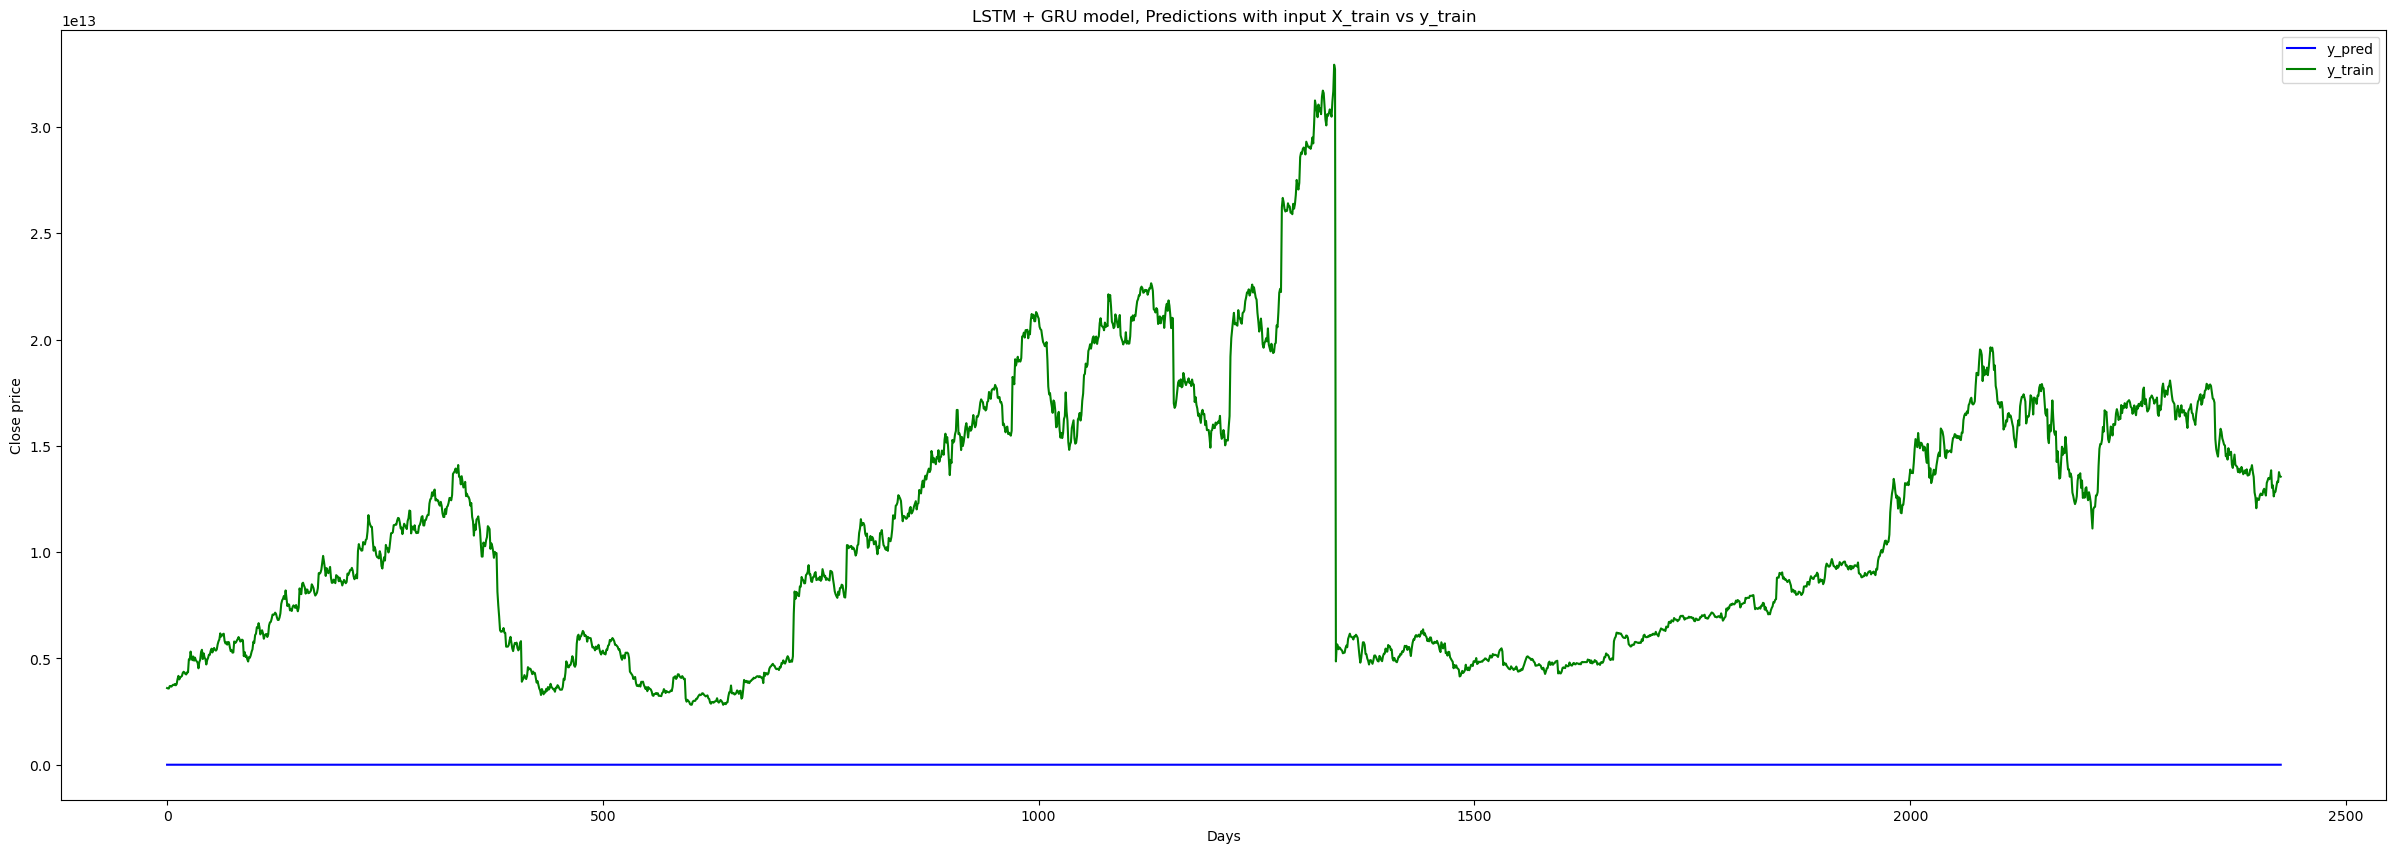

In [142]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Close price")
plt.title("LSTM + GRU model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()

Test Future Price using Past 50 days closing price

In [143]:
time_step = 50
X_input = df.iloc[-time_step:].Close.values               # getting last 50 rows and converting to array
X_input = scaler.fit_transform(X_input.reshape(-1,1))      # converting to 2D array and scaling
X_input = np.reshape(X_input, (1,50,1))                    # reshaping : converting to 3D array
print("Shape of X_input :", X_input.shape)
X_input

Shape of X_input : (1, 50, 1)


array([[[0.        ],
        [0.20193753],
        [0.15817605],
        [0.22548856],
        [0.44746952],
        [0.53115083],
        [0.51377986],
        [0.65675631],
        [0.66477368],
        [0.71571739],
        [0.74177384],
        [0.73525973],
        [0.73242024],
        [0.70218807],
        [0.64840488],
        [0.51094037],
        [0.31317855],
        [0.33405712],
        [0.19341907],
        [0.28144313],
        [0.31084015],
        [0.41322866],
        [0.46517454],
        [0.74878904],
        [0.57925505],
        [0.61650242],
        [0.85134458],
        [1.        ],
        [0.90395858],
        [0.94304326],
        [0.86203441],
        [0.93602806],
        [0.94604977],
        [0.92467012],
        [0.86403875],
        [0.55704025],
        [0.58643728],
        [0.66009688],
        [0.64990813],
        [0.83313847],
        [0.78403207],
        [0.72122933],
        [0.95339903],
        [0.95222983],
        [0.76983464],
        [0

In [144]:
LSTM_GRU_prediction = scaler.inverse_transform(regressor.predict(X_input))
print("Close price prediction for 2024-01-24:", LSTM_GRU_prediction[0,0])

1/1 [==============================] - 0s 37ms/step
Close price prediction for 2024-01-24: 9821.217


## Model 2

In [80]:
#build LSTM + GRU model

from keras.models import Sequential
from keras.layers import LSTM, GRU, Dropout, Dense

regressor = Sequential()

# 1st LSTM layer with Dropout regularisation
regressor.add(LSTM(units=256, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.3))

# 1st GRU layer
regressor.add(GRU(units=128, return_sequences=True))
regressor.add(Dropout(0.2))

# 2nd LSTM layer with Dropout regularisation
regressor.add(LSTM(units=64, return_sequences=True))
regressor.add(Dropout(0.2))

# 2nd GRU layer
regressor.add(GRU(units=32, activation='tanh'))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

regressor.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 50, 256)           264192    
                                                                 
 dropout_20 (Dropout)        (None, 50, 256)           0         
                                                                 
 gru_10 (GRU)                (None, 50, 128)           148224    
                                                                 
 dropout_21 (Dropout)        (None, 50, 128)           0         
                                                                 
 lstm_11 (LSTM)              (None, 50, 64)            49408     
                                                                 
 dropout_22 (Dropout)        (None, 50, 64)            0         
                                                                 
 gru_11 (GRU)                (None, 32)               

In [81]:
# Train the model
regressor.compile(optimizer='adam',loss='mean_squared_error')
history = regressor.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
76/76 [==============================] - 13s 86ms/step - loss: 67983.2656
Epoch 2/30
76/76 [==============================] - 7s 93ms/step - loss: 66434.7578
Epoch 3/30
76/76 [==============================] - 7s 93ms/step - loss: 65291.0156
Epoch 4/30
76/76 [==============================] - 7s 87ms/step - loss: 64243.1602
Epoch 5/30
76/76 [==============================] - 6s 84ms/step - loss: 63153.9141
Epoch 6/30
76/76 [==============================] - 6s 82ms/step - loss: 62168.9375
Epoch 7/30
76/76 [==============================] - 6s 83ms/step - loss: 61132.8555
Epoch 8/30
76/76 [==============================] - 6s 84ms/step - loss: 60099.6602
Epoch 9/30
76/76 [==============================] - 7s 87ms/step - loss: 59120.3086
Epoch 10/30
76/76 [==============================] - 7s 89ms/step - loss: 58198.8477
Epoch 11/30
76/76 [==============================] - 7s 88ms/step - loss: 57194.1367
Epoch 12/30
76/76 [==============================] - 7s 88ms/step - loss:

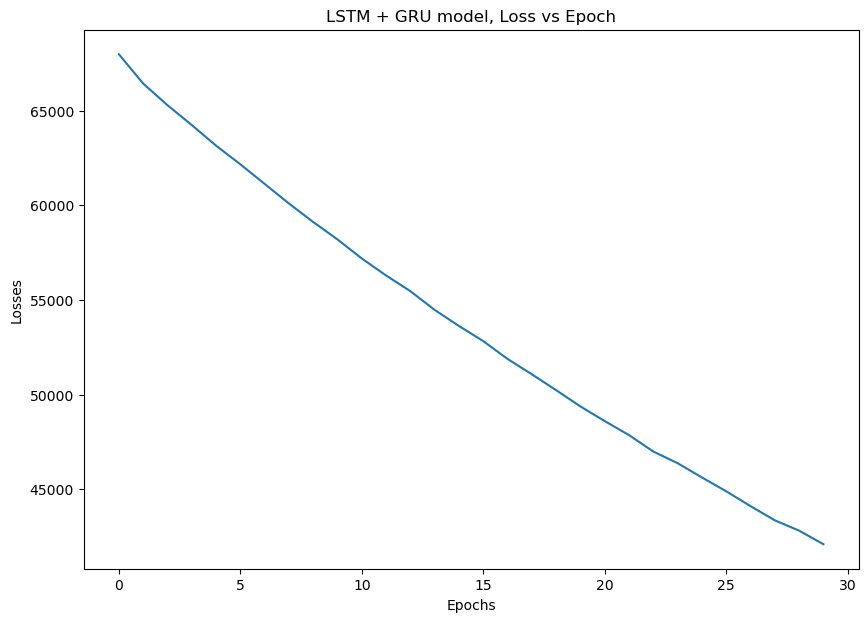

In [82]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM + GRU model, Loss vs Epoch")
plt.show()

Evaluate Test Data

In [83]:
X_test = []
y_test = []

time_step = 50

for i in range(time_step, length_train):
    X_test.append(dataset_train_scaled[i-time_step:i,0])
    y_test.append(dataset_train_scaled[i,0])
    
# convert list to array
X_test, y_test = np.array(X_test), np.array(y_test)

In [84]:
test_loss = regressor.evaluate(X_test, y_test)
print(f"Test loss: {test_loss:.4f}")

76/76 [==============================] - 4s 34ms/step - loss: 5800.7080
Test loss: 5800.7080


Model Predictions

In [85]:
y_pred = regressor.predict(X_train)  # predictions
y_pred = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_pred.shape

76/76 [==============================] - 4s 31ms/step


(2426, 1)

In [86]:
y_train = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train.shape

(2426, 1)

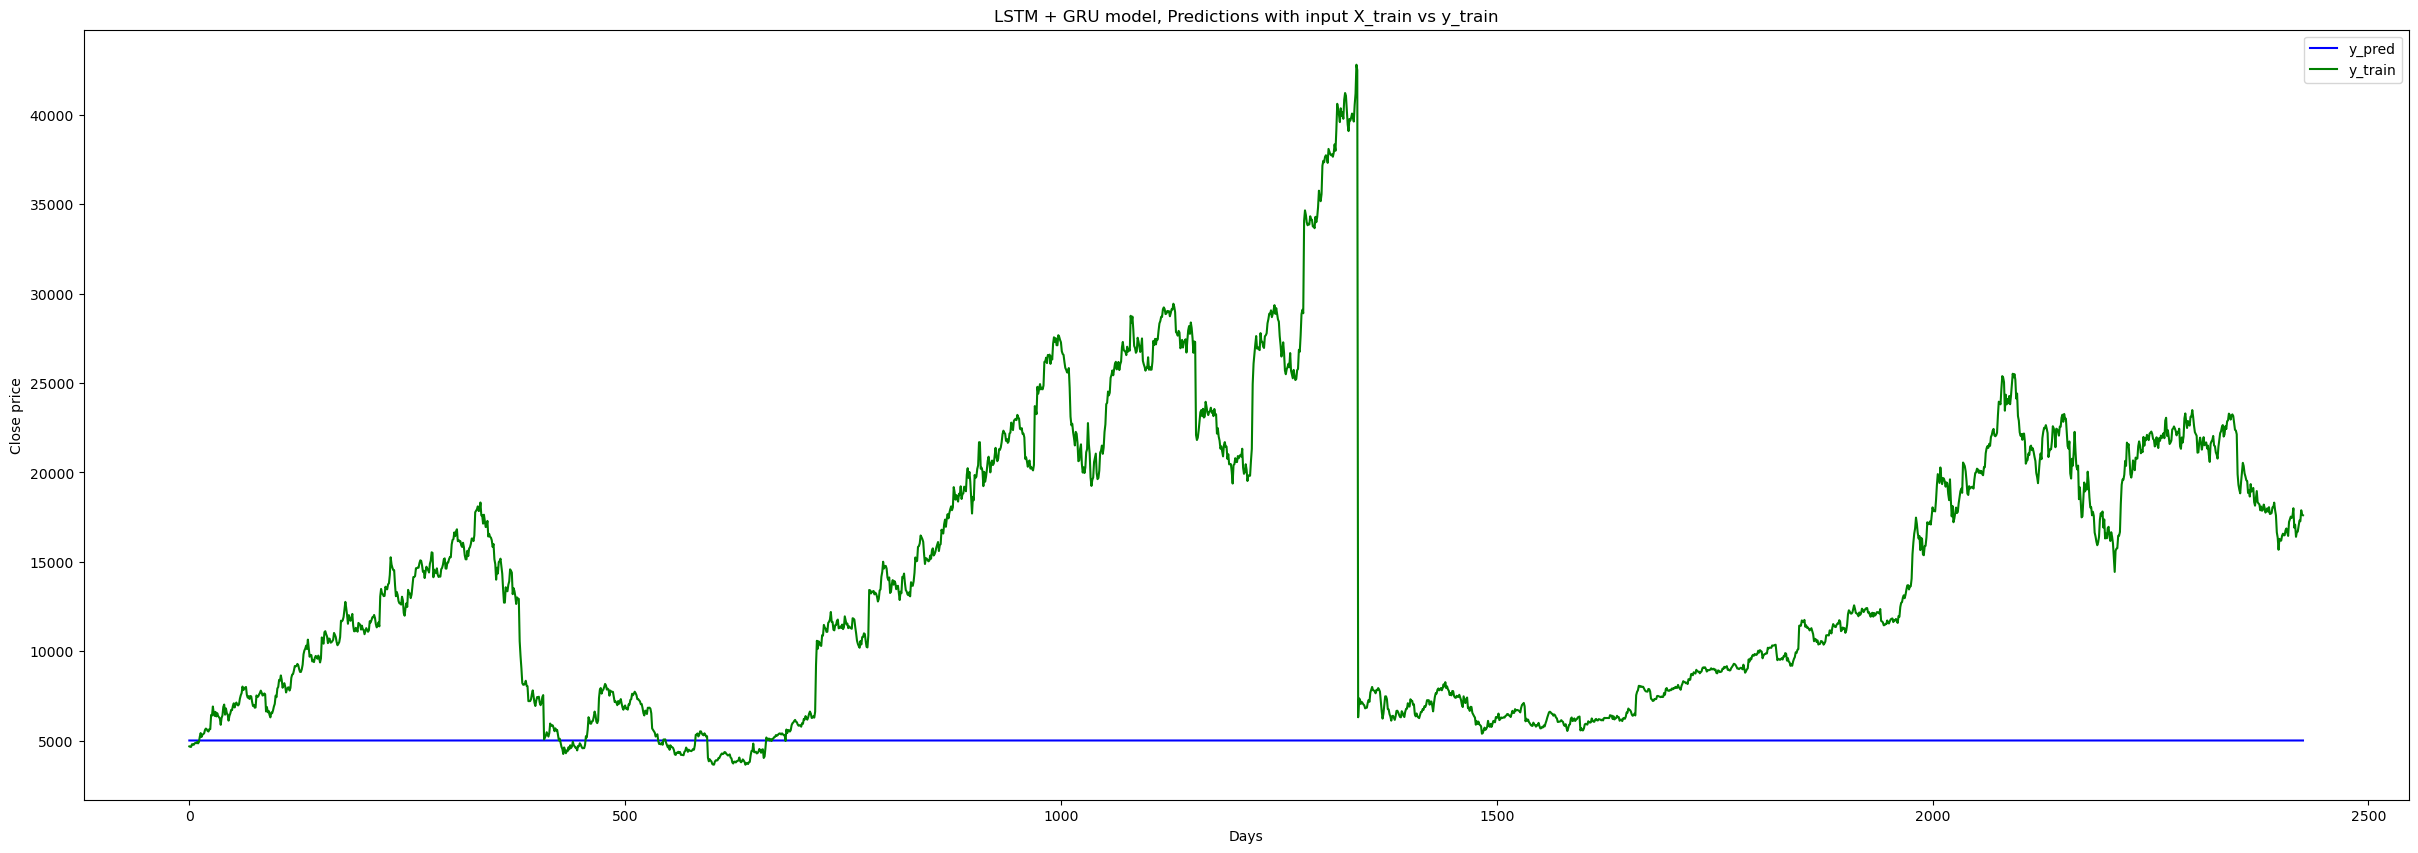

In [87]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Close price")
plt.title("LSTM + GRU model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()

Test Future Price using Past 50 days closing price

In [88]:
time_step = 50
X_input = df.iloc[-time_step:].Close.values               # getting last 50 rows and converting to array
X_input = scaler.fit_transform(X_input.reshape(-1,1))      # converting to 2D array and scaling
X_input = np.reshape(X_input, (1,50,1))                    # reshaping : converting to 3D array
print("Shape of X_input :", X_input.shape)
X_input

Shape of X_input : (1, 50, 1)


array([[[0.        ],
        [0.20193753],
        [0.15817605],
        [0.22548856],
        [0.44746952],
        [0.53115083],
        [0.51377986],
        [0.65675631],
        [0.66477368],
        [0.71571739],
        [0.74177384],
        [0.73525973],
        [0.73242024],
        [0.70218807],
        [0.64840488],
        [0.51094037],
        [0.31317855],
        [0.33405712],
        [0.19341907],
        [0.28144313],
        [0.31084015],
        [0.41322866],
        [0.46517454],
        [0.74878904],
        [0.57925505],
        [0.61650242],
        [0.85134458],
        [1.        ],
        [0.90395858],
        [0.94304326],
        [0.86203441],
        [0.93602806],
        [0.94604977],
        [0.92467012],
        [0.86403875],
        [0.55704025],
        [0.58643728],
        [0.66009688],
        [0.64990813],
        [0.83313847],
        [0.78403207],
        [0.72122933],
        [0.95339903],
        [0.95222983],
        [0.76983464],
        [0

In [89]:
LSTM_GRU_prediction = scaler.inverse_transform(regressor.predict(X_input))
print("Close price prediction for 2024-01-24:", LSTM_GRU_prediction[0,0])

1/1 [==============================] - 0s 45ms/step
Close price prediction for 2024-01-24: 5011.4844


## Model 3

In [91]:
#build LSTM + GRU model

from keras.models import Sequential
from keras.layers import LSTM, GRU, Dropout, Dense

regressor = Sequential()

# 1st LSTM layer with Dropout regularisation
regressor.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.3))

# 1st GRU layer
regressor.add(GRU(units=64, return_sequences=True))
regressor.add(Dropout(0.2))

# 2nd LSTM layer with Dropout regularisation
regressor.add(LSTM(units=32, return_sequences=True))
regressor.add(Dropout(0.2))

# 2nd GRU layer
regressor.add(GRU(units=16, activation='tanh'))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

regressor.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 50, 128)           66560     
                                                                 
 dropout_24 (Dropout)        (None, 50, 128)           0         
                                                                 
 gru_12 (GRU)                (None, 50, 64)            37248     
                                                                 
 dropout_25 (Dropout)        (None, 50, 64)            0         
                                                                 
 lstm_13 (LSTM)              (None, 50, 32)            12416     
                                                                 
 dropout_26 (Dropout)        (None, 50, 32)            0         
                                                                 
 gru_13 (GRU)                (None, 16)               

In [92]:
# Train the model
regressor.compile(optimizer='adam',loss='mean_squared_error')
history = regressor.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
76/76 [==============================] - 11s 55ms/step - loss: 267091504.0000
Epoch 2/30
76/76 [==============================] - 4s 53ms/step - loss: 267026832.0000
Epoch 3/30
76/76 [==============================] - 4s 55ms/step - loss: 266986512.0000
Epoch 4/30
76/76 [==============================] - 4s 51ms/step - loss: 266947936.0000
Epoch 5/30
76/76 [==============================] - 4s 52ms/step - loss: 266911680.0000
Epoch 6/30
76/76 [==============================] - 4s 54ms/step - loss: 266872432.0000
Epoch 7/30
76/76 [==============================] - 4s 52ms/step - loss: 266836688.0000
Epoch 8/30
76/76 [==============================] - 4s 54ms/step - loss: 266797488.0000
Epoch 9/30
76/76 [==============================] - 4s 52ms/step - loss: 266759392.0000
Epoch 10/30
76/76 [==============================] - 4s 53ms/step - loss: 266725664.0000
Epoch 11/30
76/76 [==============================] - 4s 52ms/step - loss: 266687264.0000
Epoch 12/30
76/76 [==========

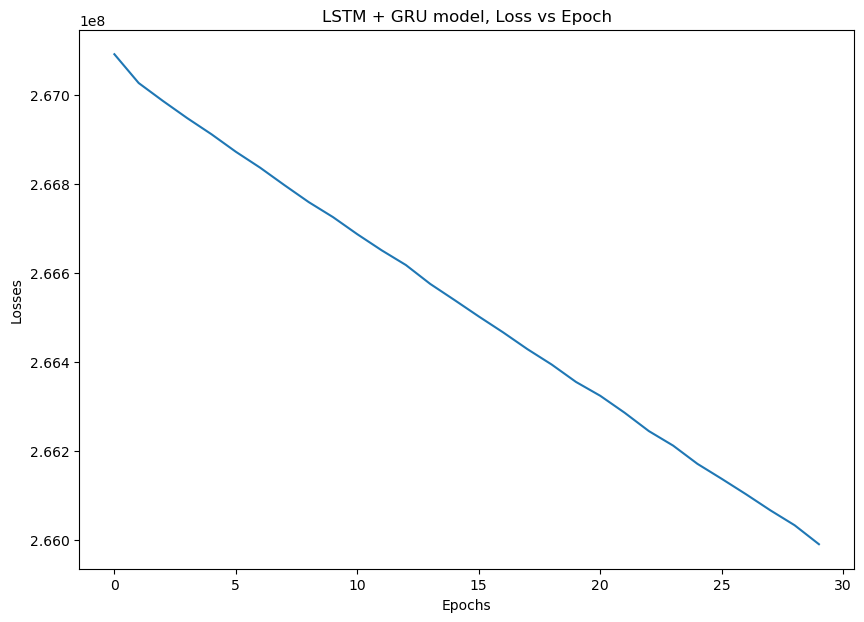

In [93]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM + GRU model, Loss vs Epoch")
plt.show()

Evaluate Test Data

In [94]:
X_test = []
y_test = []

time_step = 50

for i in range(time_step, length_train):
    X_test.append(dataset_train_scaled[i-time_step:i,0])
    y_test.append(dataset_train_scaled[i,0])
    
# convert list to array
X_test, y_test = np.array(X_test), np.array(y_test)

In [95]:
test_loss = regressor.evaluate(X_test, y_test)
print(f"Test loss: {test_loss:.4f}")

76/76 [==============================] - 3s 19ms/step - loss: 1918.2782
Test loss: 1918.2782


Model Predictions

In [96]:
y_pred = regressor.predict(X_train)  # predictions
y_pred = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_pred.shape

76/76 [==============================] - 3s 17ms/step


(2426, 1)

In [97]:
y_train = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train.shape

(2426, 1)

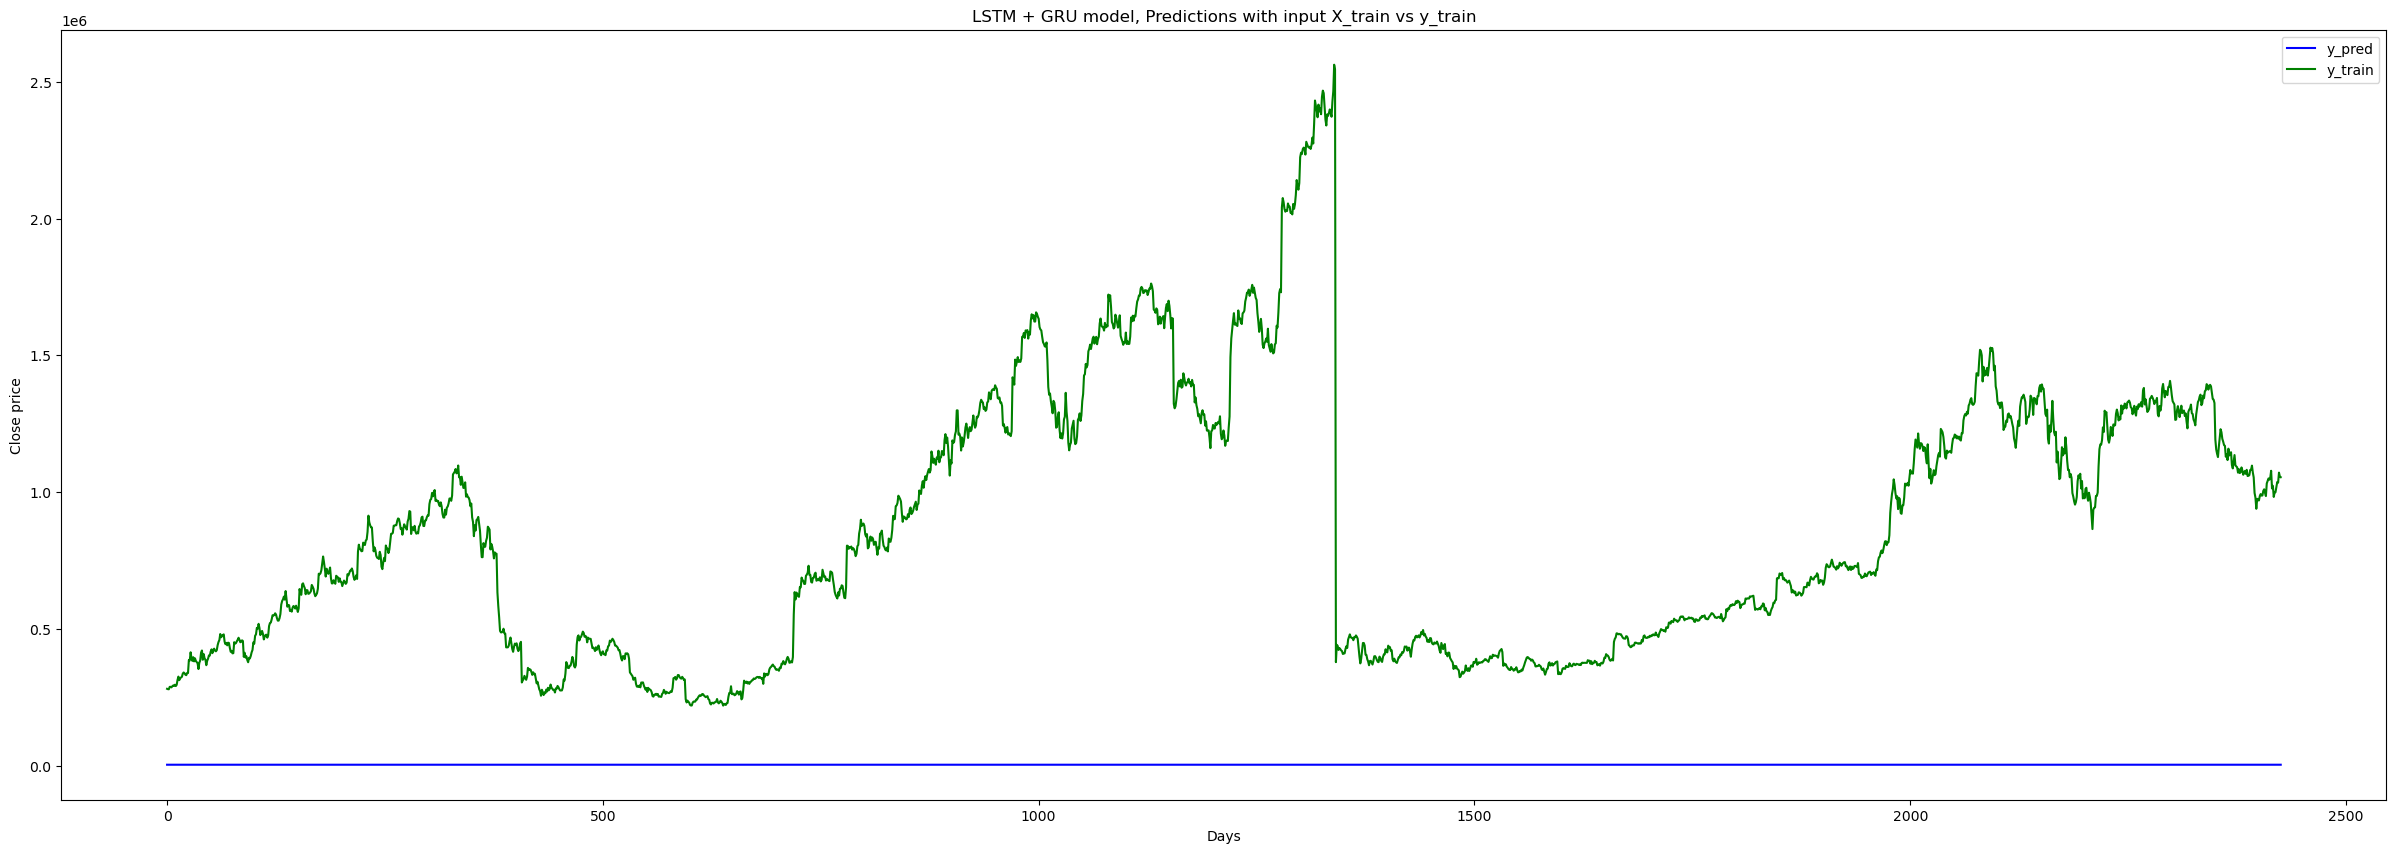

In [98]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Close price")
plt.title("LSTM + GRU model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()

Test Future Price using Past 50 days closing price

In [99]:
time_step = 50
X_input = df.iloc[-time_step:].Close.values               # getting last 50 rows and converting to array
X_input = scaler.fit_transform(X_input.reshape(-1,1))      # converting to 2D array and scaling
X_input = np.reshape(X_input, (1,50,1))                    # reshaping : converting to 3D array
print("Shape of X_input :", X_input.shape)
X_input

Shape of X_input : (1, 50, 1)


array([[[0.        ],
        [0.20193753],
        [0.15817605],
        [0.22548856],
        [0.44746952],
        [0.53115083],
        [0.51377986],
        [0.65675631],
        [0.66477368],
        [0.71571739],
        [0.74177384],
        [0.73525973],
        [0.73242024],
        [0.70218807],
        [0.64840488],
        [0.51094037],
        [0.31317855],
        [0.33405712],
        [0.19341907],
        [0.28144313],
        [0.31084015],
        [0.41322866],
        [0.46517454],
        [0.74878904],
        [0.57925505],
        [0.61650242],
        [0.85134458],
        [1.        ],
        [0.90395858],
        [0.94304326],
        [0.86203441],
        [0.93602806],
        [0.94604977],
        [0.92467012],
        [0.86403875],
        [0.55704025],
        [0.58643728],
        [0.66009688],
        [0.64990813],
        [0.83313847],
        [0.78403207],
        [0.72122933],
        [0.95339903],
        [0.95222983],
        [0.76983464],
        [0

In [100]:
LSTM_GRU_prediction = scaler.inverse_transform(regressor.predict(X_input))
print("Close price prediction for 2024-01-24:", LSTM_GRU_prediction[0,0])

1/1 [==============================] - 0s 33ms/step
Close price prediction for 2024-01-24: 3073.825


## Model 4

In [102]:
#build LSTM + GRU model

from keras.models import Sequential
from keras.layers import LSTM, GRU, Dropout, Dense

regressor = Sequential()

# 1st LSTM layer with Dropout regularisation
regressor.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.3))

# 1st GRU layer
regressor.add(GRU(units=32, return_sequences=True))

# 2nd LSTM layer with Dropout regularisation
regressor.add(LSTM(units=16, return_sequences=True))

# 2nd GRU layer
regressor.add(GRU(units=8, activation='tanh'))

regressor.add(Dense(units=1))

regressor.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 50, 64)            16896     
                                                                 
 dropout_28 (Dropout)        (None, 50, 64)            0         
                                                                 
 gru_14 (GRU)                (None, 50, 32)            9408      
                                                                 
 lstm_15 (LSTM)              (None, 50, 16)            3136      
                                                                 
 gru_15 (GRU)                (None, 8)                 624       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 30073 (117.47 KB)
Trainable params: 3007

In [103]:
# Train the model
regressor.compile(optimizer='adam',loss='mean_squared_error')
history = regressor.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
76/76 [==============================] - 10s 42ms/step - loss: 958598938624.0000
Epoch 2/30
76/76 [==============================] - 3s 41ms/step - loss: 958595399680.0000
Epoch 3/30
76/76 [==============================] - 3s 40ms/step - loss: 958593957888.0000
Epoch 4/30
76/76 [==============================] - 3s 44ms/step - loss: 958592843776.0000
Epoch 5/30
76/76 [==============================] - 3s 44ms/step - loss: 958591533056.0000
Epoch 6/30
76/76 [==============================] - 3s 43ms/step - loss: 958590287872.0000
Epoch 7/30
76/76 [==============================] - 3s 45ms/step - loss: 958589108224.0000
Epoch 8/30
76/76 [==============================] - 3s 44ms/step - loss: 958587863040.0000
Epoch 9/30
76/76 [==============================] - 3s 42ms/step - loss: 958586552320.0000
Epoch 10/30
76/76 [==============================] - 3s 42ms/step - loss: 958585241600.0000
Epoch 11/30
76/76 [==============================] - 3s 43ms/step - loss: 958584258560.0

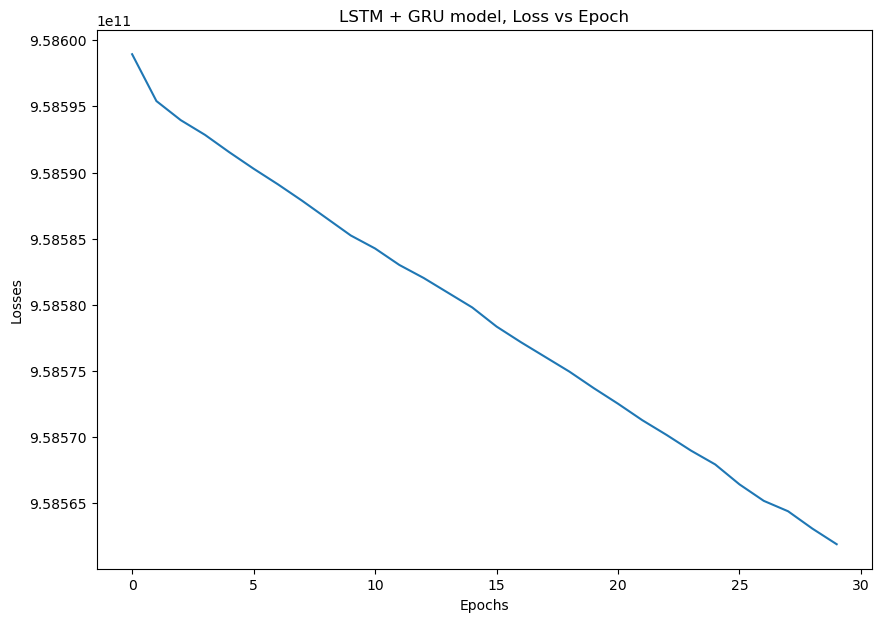

In [104]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM + GRU model, Loss vs Epoch")
plt.show()

Evaluate Test Data

In [105]:
X_test = []
y_test = []

time_step = 50

for i in range(time_step, length_train):
    X_test.append(dataset_train_scaled[i-time_step:i,0])
    y_test.append(dataset_train_scaled[i,0])
    
# convert list to array
X_test, y_test = np.array(X_test), np.array(y_test)

In [106]:
test_loss = regressor.evaluate(X_test, y_test)
print(f"Test loss: {test_loss:.4f}")

76/76 [==============================] - 2s 13ms/step - loss: 593.0964
Test loss: 593.0964


Model Predictions

In [107]:
y_pred = regressor.predict(X_train)  # predictions
y_pred = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_pred.shape

76/76 [==============================] - 2s 12ms/step


(2426, 1)

In [108]:
y_train = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train.shape

(2426, 1)

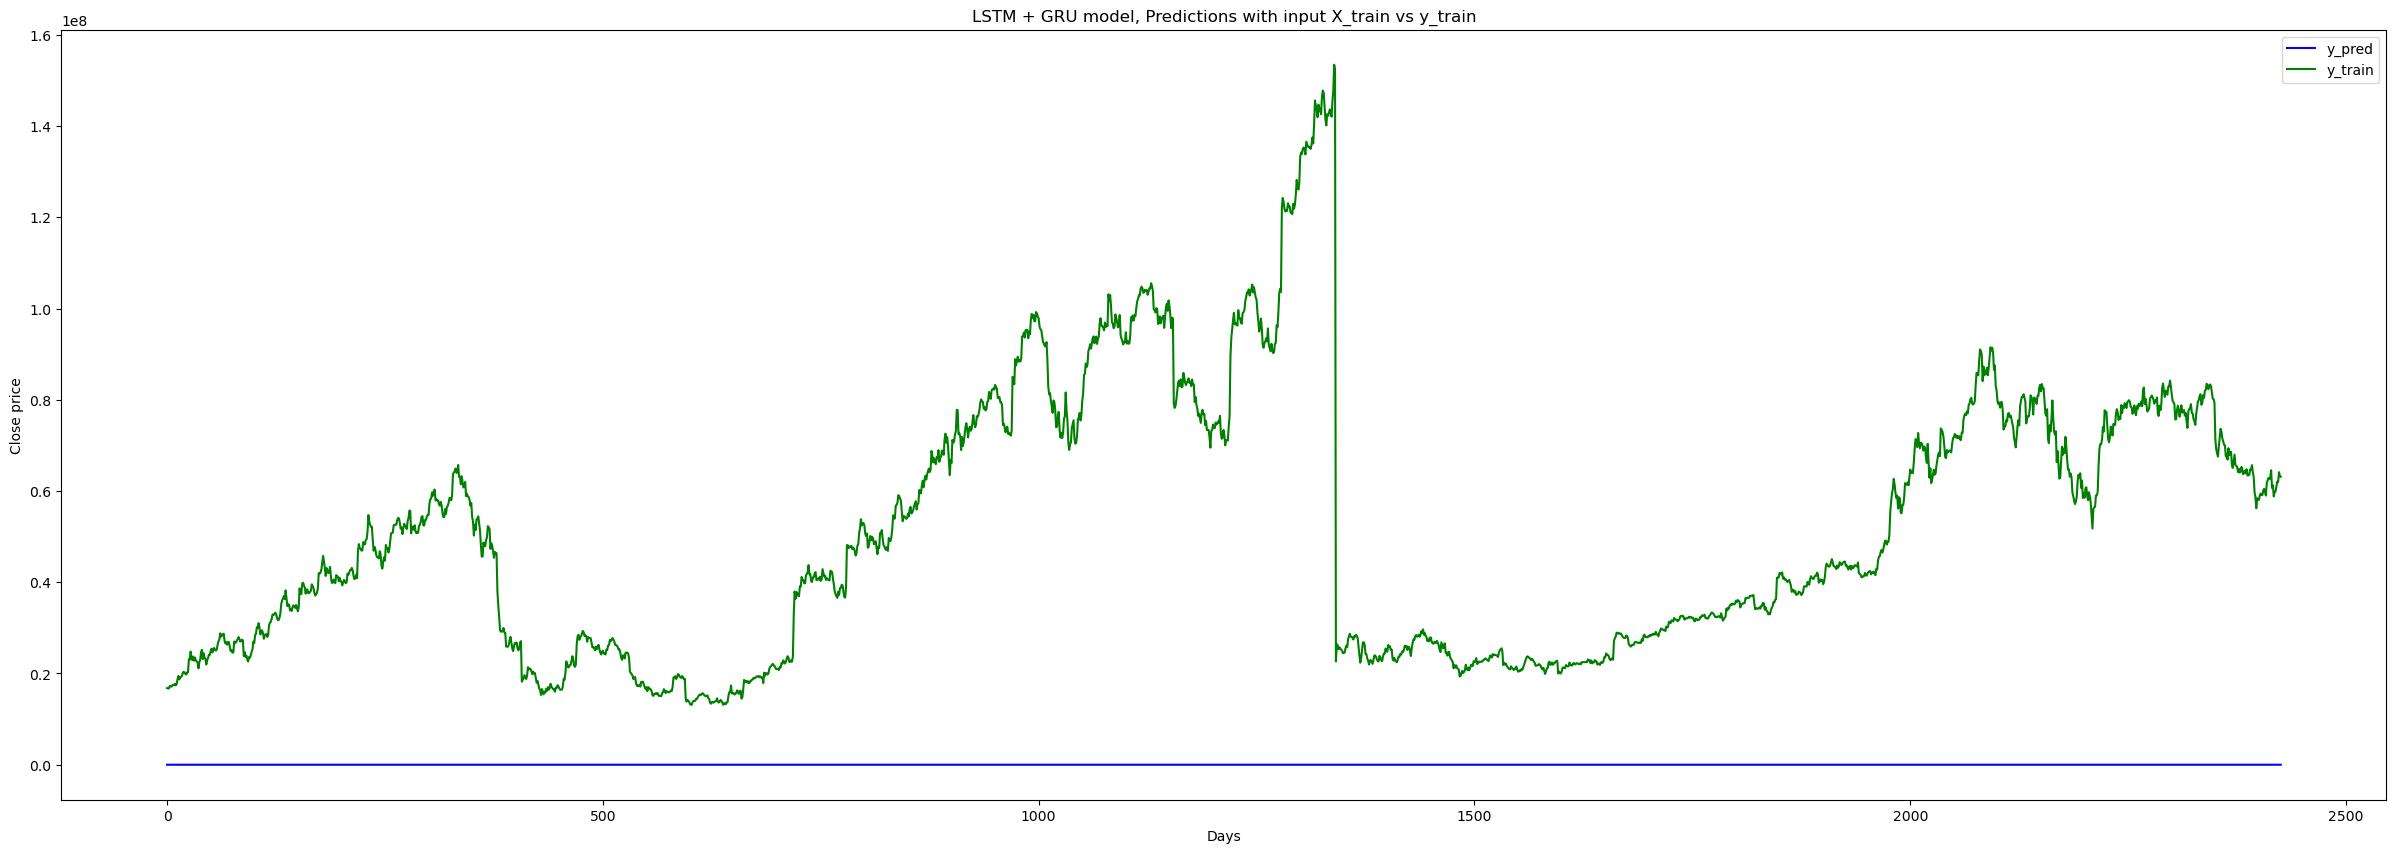

In [109]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Close price")
plt.title("LSTM + GRU model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()

Test Future Price using Past 50 days closing price

In [110]:
time_step = 50
X_input = df.iloc[-time_step:].Close.values               # getting last 50 rows and converting to array
X_input = scaler.fit_transform(X_input.reshape(-1,1))      # converting to 2D array and scaling
X_input = np.reshape(X_input, (1,50,1))                    # reshaping : converting to 3D array
print("Shape of X_input :", X_input.shape)
X_input

Shape of X_input : (1, 50, 1)


array([[[0.        ],
        [0.20193753],
        [0.15817605],
        [0.22548856],
        [0.44746952],
        [0.53115083],
        [0.51377986],
        [0.65675631],
        [0.66477368],
        [0.71571739],
        [0.74177384],
        [0.73525973],
        [0.73242024],
        [0.70218807],
        [0.64840488],
        [0.51094037],
        [0.31317855],
        [0.33405712],
        [0.19341907],
        [0.28144313],
        [0.31084015],
        [0.41322866],
        [0.46517454],
        [0.74878904],
        [0.57925505],
        [0.61650242],
        [0.85134458],
        [1.        ],
        [0.90395858],
        [0.94304326],
        [0.86203441],
        [0.93602806],
        [0.94604977],
        [0.92467012],
        [0.86403875],
        [0.55704025],
        [0.58643728],
        [0.66009688],
        [0.64990813],
        [0.83313847],
        [0.78403207],
        [0.72122933],
        [0.95339903],
        [0.95222983],
        [0.76983464],
        [0

In [112]:
LSTM_GRU_prediction = scaler.inverse_transform(regressor.predict(X_input))
print("Close price prediction for 2024-01-24:", LSTM_GRU_prediction[0,0])

1/1 [==============================] - 0s 22ms/step
Close price prediction for 2024-01-24: 1909.6556


## Model 5

In [113]:
#build LSTM + GRU model

from keras.models import Sequential
from keras.layers import LSTM, GRU, Dropout, Dense

regressor = Sequential()

# 1st LSTM layer with Dropout regularisation
regressor.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1],1)))

# 1st GRU layer
regressor.add(GRU(units=16, return_sequences=True))

# 2nd LSTM layer with Dropout regularisation
regressor.add(LSTM(units=8, return_sequences=True))

# 2nd GRU layer
regressor.add(GRU(units=4, activation='tanh'))

regressor.add(Dense(units=1))

regressor.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 50, 32)            4352      
                                                                 
 gru_16 (GRU)                (None, 50, 16)            2400      
                                                                 
 lstm_17 (LSTM)              (None, 50, 8)             800       
                                                                 
 gru_17 (GRU)                (None, 4)                 168       
                                                                 
 dense_8 (Dense)             (None, 1)                 5         
                                                                 
Total params: 7725 (30.18 KB)
Trainable params: 7725 (30.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [114]:
# Train the model
regressor.compile(optimizer='adam',loss='mean_squared_error')
history = regressor.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
76/76 [==============================] - 10s 37ms/step - loss: 3436078526627840.0000
Epoch 2/30
76/76 [==============================] - 3s 36ms/step - loss: 3436078526627840.0000
Epoch 3/30
76/76 [==============================] - 3s 37ms/step - loss: 3436078258192384.0000
Epoch 4/30
76/76 [==============================] - 3s 37ms/step - loss: 3436078258192384.0000
Epoch 5/30
76/76 [==============================] - 3s 36ms/step - loss: 3436077721321472.0000
Epoch 6/30
76/76 [==============================] - 3s 37ms/step - loss: 3436078258192384.0000
Epoch 7/30
76/76 [==============================] - 3s 39ms/step - loss: 3436078526627840.0000
Epoch 8/30
76/76 [==============================] - 3s 37ms/step - loss: 3436077989756928.0000
Epoch 9/30
76/76 [==============================] - 3s 37ms/step - loss: 3436077721321472.0000
Epoch 10/30
76/76 [==============================] - 3s 37ms/step - loss: 3436077721321472.0000
Epoch 11/30
76/76 [=============================

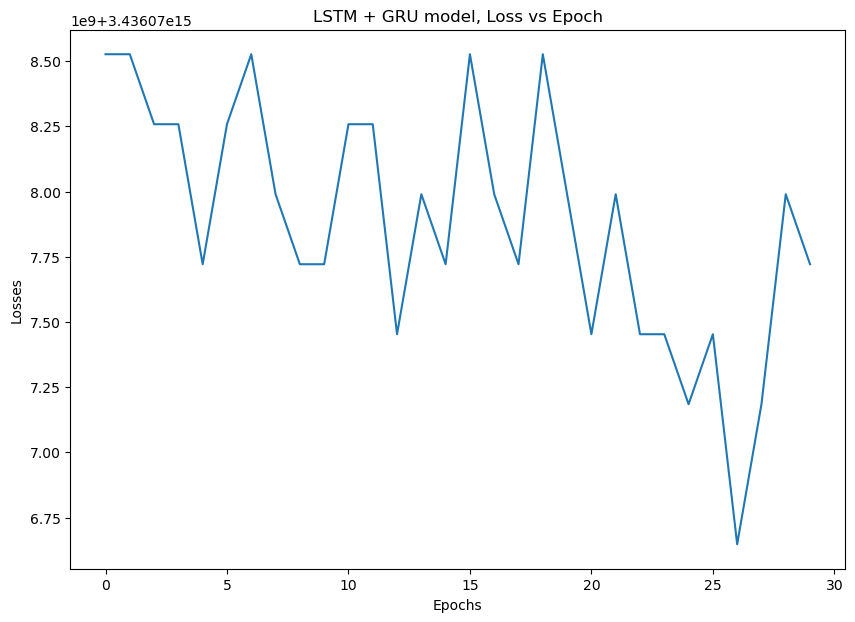

In [115]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM + GRU model, Loss vs Epoch")
plt.show()

Evaluate Test Data

In [116]:
X_test = []
y_test = []

time_step = 50

for i in range(time_step, length_train):
    X_test.append(dataset_train_scaled[i-time_step:i,0])
    y_test.append(dataset_train_scaled[i,0])
    
# convert list to array
X_test, y_test = np.array(X_test), np.array(y_test)

In [117]:
test_loss = regressor.evaluate(X_test, y_test)
print(f"Test loss: {test_loss:.4f}")

76/76 [==============================] - 2s 10ms/step - loss: 178.4487
Test loss: 178.4487


Model Predictions

In [118]:
y_pred = regressor.predict(X_train)  # predictions
y_pred = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_pred.shape

76/76 [==============================] - 2s 10ms/step


(2426, 1)

In [119]:
y_train = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train.shape

(2426, 1)

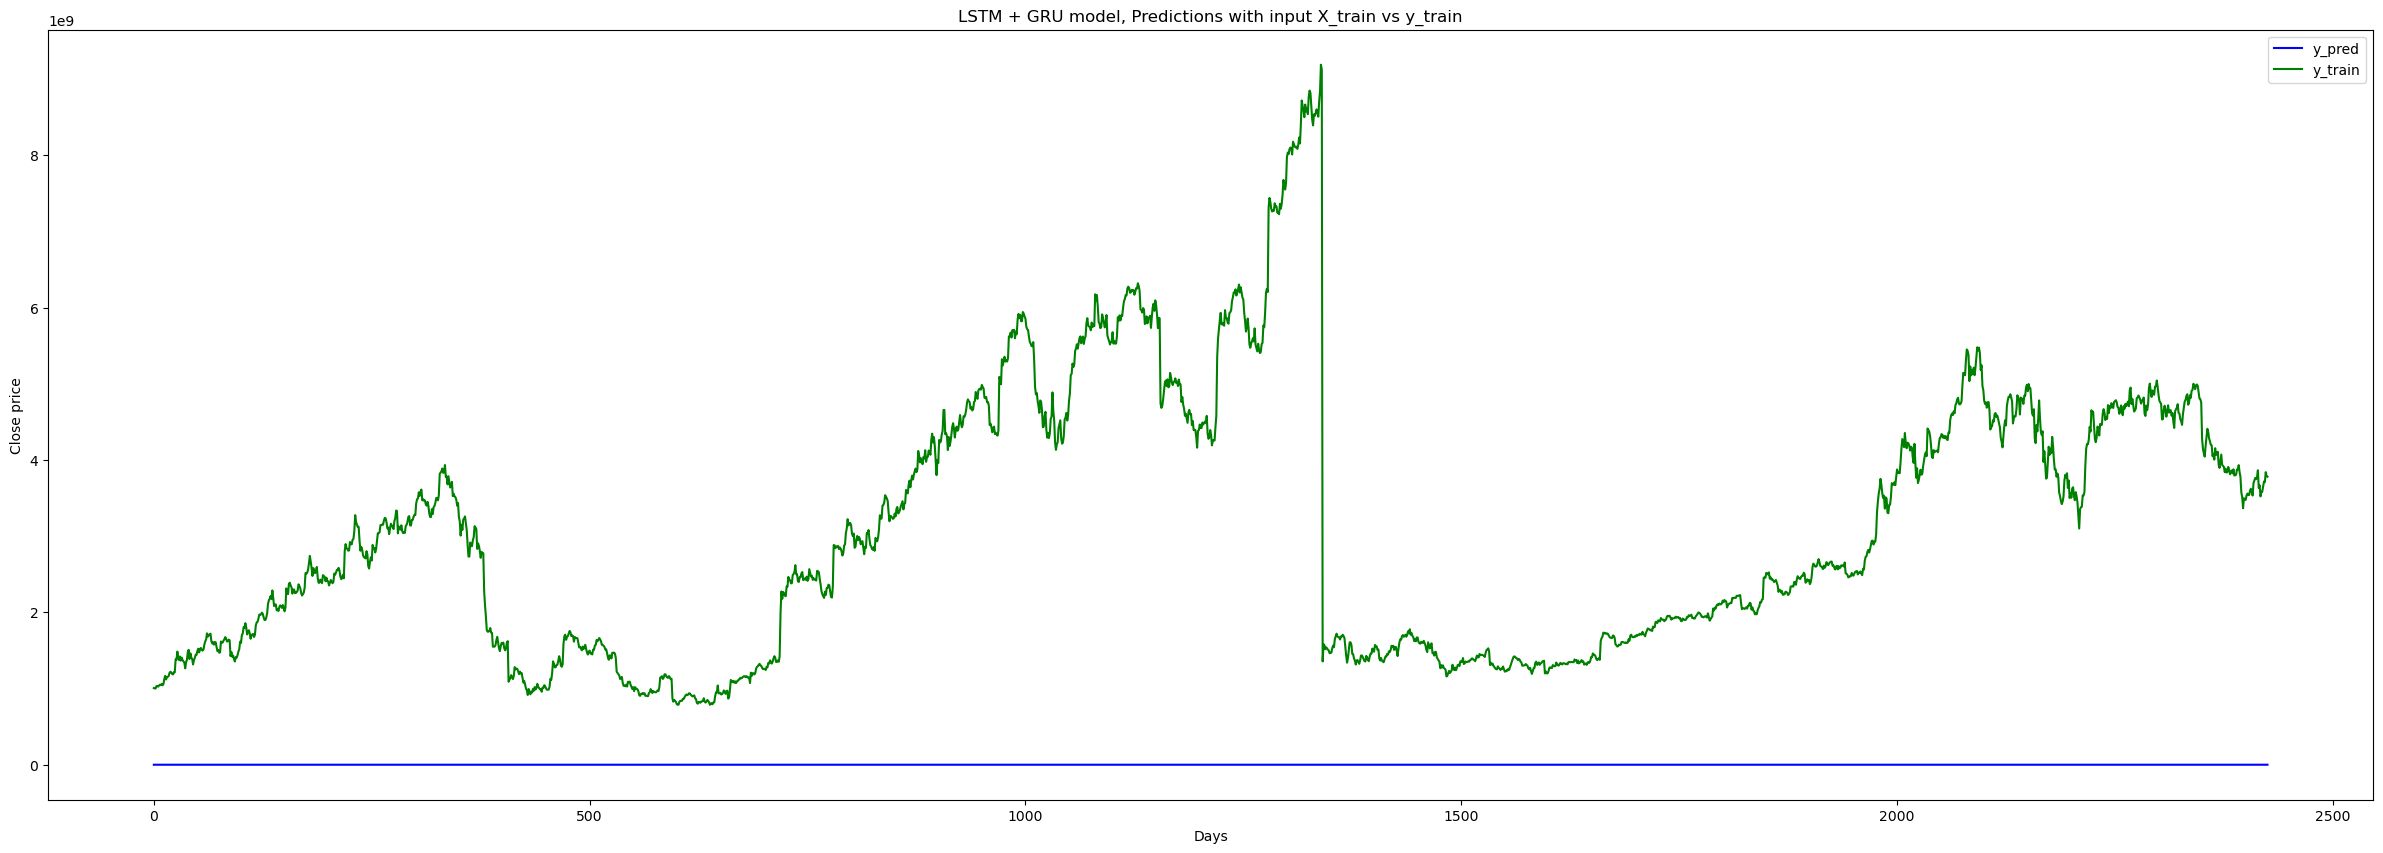

In [120]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Close price")
plt.title("LSTM + GRU model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()

Test Future Price using Past 50 days closing price

In [121]:
time_step = 50
X_input = df.iloc[-time_step:].Close.values               # getting last 50 rows and converting to array
X_input = scaler.fit_transform(X_input.reshape(-1,1))      # converting to 2D array and scaling
X_input = np.reshape(X_input, (1,50,1))                    # reshaping : converting to 3D array
print("Shape of X_input :", X_input.shape)
X_input

Shape of X_input : (1, 50, 1)


array([[[0.        ],
        [0.20193753],
        [0.15817605],
        [0.22548856],
        [0.44746952],
        [0.53115083],
        [0.51377986],
        [0.65675631],
        [0.66477368],
        [0.71571739],
        [0.74177384],
        [0.73525973],
        [0.73242024],
        [0.70218807],
        [0.64840488],
        [0.51094037],
        [0.31317855],
        [0.33405712],
        [0.19341907],
        [0.28144313],
        [0.31084015],
        [0.41322866],
        [0.46517454],
        [0.74878904],
        [0.57925505],
        [0.61650242],
        [0.85134458],
        [1.        ],
        [0.90395858],
        [0.94304326],
        [0.86203441],
        [0.93602806],
        [0.94604977],
        [0.92467012],
        [0.86403875],
        [0.55704025],
        [0.58643728],
        [0.66009688],
        [0.64990813],
        [0.83313847],
        [0.78403207],
        [0.72122933],
        [0.95339903],
        [0.95222983],
        [0.76983464],
        [0

In [123]:
LSTM_GRU_prediction = scaler.inverse_transform(regressor.predict(X_input))
print("Close price prediction for 2024-01-24:", LSTM_GRU_prediction[0,0])

1/1 [==============================] - 0s 29ms/step
Close price prediction for 2024-01-24: 1251.3372
